In [1]:
import pandas as pd
import numpy as np
import math
import time
from datetime import datetime
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler

pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


In [2]:
# TODO

# change the date and period to an int (either month and year as seperate columns or a timestamp)
# experiment with column combinations more
# experiment with training on whole dataset

In [3]:
df = pd.read_csv('/Users/dhruv/code/export_yardi_jourentline.csv', lineterminator='\n')
df.columns = df.columns.map(lambda c: c.strip())
df.iloc[0:5] # <- change to expand

,GLCODE,GLNAME,PROPERTY,PROPERTYNAME,UNIT,BUILDING,SPECIALCIRCUMSTANCE,USAGEAMOUNT,USAGETYPE,DATE,PERIOD,DESCRIPTION,CONTROL,REFERENCE,AMOUNT,DEBITCREDIT,BALANCE,REMARKS
0,1110-0000,Cash,ap-mc11,4203 11TH LLC,42031,,,,,09/09/2020,12/01/2020,Webster S8 (t0034597),K-396581,165,8500.0,Credit,1813181.59,First buyout check
1,1110-0000,Cash,ap-mc11,4203 11TH LLC,42032,,,,,09/29/2020,12/01/2020,Webster (t0034598),K-405215,173,2500.0,Credit,1810681.59,
2,1110-0000,Cash,ap-mc11,4203 11TH LLC,42031,,,,,10/27/2020,12/01/2020,Webster S8 (t0034597),K-417819,183,9100.0,Credit,1801581.59,
3,1110-0000,Cash,ap-mc11,4203 11TH LLC,42052,,,,,10/29/2020,12/01/2020,Jones (t0034602),K-420897,187,3500.0,Credit,1798081.59,First Buyout Check
4,1110-0000,Cash,ap-mc11,4203 11TH LLC,42053,,,,,11/02/2020,12/01/2020,Dow (t0034603),K-421957,190,3500.0,Credit,1794581.59,First Buyout Check


In [4]:
cols = ['GLCODE', 'PROPERTY', 'UNIT', 'DATE', 'PERIOD', 'AMOUNT', 'DEBITCREDIT', 'DESCRIPTION', 'REMARKS']
df = df[cols]

df['DATE'] = df['DATE'].map(lambda d: datetime.strptime(d, ' %m/%d/%Y'))
df['PERIOD'] = df['PERIOD'].map(lambda p: datetime.strptime(p, ' %m/%d/%Y'))

df['DATEDAY'] = df['DATE'].map(lambda d: int(d.day))
df['DATEMO'] = df['DATE'].map(lambda d: int(d.month))
df['DATEYR'] = df['DATE'].map(lambda d: int(d.year))

df['PERIODDAY'] = df['PERIOD'].map(lambda d: int(d.day))
df['PERIODMO'] = df['PERIOD'].map(lambda d: int(d.month))
df['PERIODYR'] = df['PERIOD'].map(lambda d: int(d.year))

df = df.drop(columns=['DATE', 'PERIOD'], axis=1)

df['REMARKS'] = df['REMARKS'].map(lambda r: r.lower())

df.head()


,GLCODE,PROPERTY,UNIT,AMOUNT,DEBITCREDIT,DESCRIPTION,REMARKS,DATEDAY,DATEMO,DATEYR,PERIODDAY,PERIODMO,PERIODYR
0,1110-0000,ap-mc11,42031,8500.0,Credit,Webster S8 (t0034597),first buyout check,9,9,2020,1,12,2020
1,1110-0000,ap-mc11,42032,2500.0,Credit,Webster (t0034598),,29,9,2020,1,12,2020
2,1110-0000,ap-mc11,42031,9100.0,Credit,Webster S8 (t0034597),,27,10,2020,1,12,2020
3,1110-0000,ap-mc11,42052,3500.0,Credit,Jones (t0034602),first buyout check,29,10,2020,1,12,2020
4,1110-0000,ap-mc11,42053,3500.0,Credit,Dow (t0034603),first buyout check,2,11,2020,1,12,2020


In [5]:
X = df.copy()
X = X.drop(['AMOUNT'], axis=1)

y = df['AMOUNT']

preXTrain, preXTest, yTrain, yTest = train_test_split(X, y, test_size=0.15, random_state=1)

#preXTrain = X
#yTrain = y
#preXTest = X
#yTest = y

preXTrain = preXTrain.reset_index(drop=True)
yTrain = yTrain.reset_index(drop=True)
preXTest = preXTest.reset_index(drop=True)
yTest = yTest.reset_index(drop=True)


In [6]:
catCols = [col for col in X.columns if X[col].dtype == 'object']


In [7]:
labelXTrain = preXTrain.copy()
labelXTest = preXTest.copy()

le = LabelEncoder()

for col in catCols:
    le.fit(labelXTrain[col])
    
    labelXTest[col] = labelXTest[col].map(lambda s: '<unknown>' if s not in le.classes_ else s)
    
    le.classes_ = np.append(le.classes_, '<unknown>')
    
    labelXTrain[col] = le.transform(labelXTrain[col])
    labelXTest[col] = le.transform(labelXTest[col])
    
XTrain = labelXTrain.copy()
XTest = labelXTest.copy()


In [8]:
model = RandomForestRegressor(n_estimators=25, random_state=0)
model.fit(XTrain, yTrain)

testPreds = pd.Series(model.predict(XTest))
testPreds = testPreds.map(lambda pred: round(pred, 2))


In [9]:
def categorizePercents(p):
    if p>=0 and p<5:
        return 5
    elif p>=5 and p<10:
        return 10
    elif p>=10 and p<20:
        return 20
    elif p>=20 and p<50:
        return 50
    elif p>=50 and p<100:
        return 100
    elif p>=100 and p<200:
        return 200
    elif p>=200 and p<500:
        return 500
    elif p>=500 and p<1000:
        return 1000
    elif p>=1000:
        return 10000
    else:
        return 'unknown'
    

In [10]:
def modelReport(yTest, testPreds):
    
    percentsList = []
    goodCodesDict = {}

    for i in range(0, len(yTest)):

        real = yTest[i]
        pred = testPreds[i]

        percentOfReal = (pred/real)*100
        percentOff = abs(100-percentOfReal)

        percentsList.append(round(percentOff, 2))
      
        
    percentsDf = pd.DataFrame(percentsList, columns=['percentOff'])

    percentsDf['category'] = percentsDf.apply(lambda p: categorizePercents(p['percentOff']), axis=1)

    percentRangeDf = percentsDf.groupby('category').size().reset_index(name='count')
    percentRangeDf['percentOfTotal'] = round(percentRangeDf['count']/len(percentsDf.index)*100)

    # Data Overview
    
    print('*DATA REPORT*')
    print('AVG:', sum(yTest) / len(yTest))
    print('MIN:', min(yTest))
    print('MAX:', max(yTest))
    print('LEN:', len(yTest))
    
    print('')
    
    # Scores
    
    print('*SCORE REPORT*')
    print('R2:', round(metrics.r2_score(yTest, testPreds), 3))
    print('MAE:', round(metrics.mean_absolute_error(yTest, testPreds)))
    print('RMSE:', round(metrics.mean_squared_error(yTest, testPreds, squared=False)))
    print('')
    
    # Percent Distribution
    
    def pct(rowNo):
        return int(percentRangeDf['percentOfTotal'][rowNo])
    
    print('*DISTRIBUTION REPORT*')
    print(pct(0), pct(1), pct(2), pct(3), pct(4), pct(5), pct(6), pct(7), pct(8))
    
    # Comparison Plot
    
    comparison = pd.concat([yTest, testPreds], axis=1)
    comparison.columns = ['actual', 'predicted']
    
    plt.figure(figsize=(8,5))
    plt.title('Predictions vs. Actual Values')
    
    sns.lineplot(data=comparison.iloc[0:75])
    
    # Percent Distribution Plot

    plt.figure(figsize=(8,5))
    plt.title('Bar Chart of Percent Distributions')

    sns.barplot(x=percentRangeDf['category'], y=percentRangeDf['count'])


*DATA REPORT*
AVG: 2118.684535947637
MIN: 0.01
MAX: 3840000.0
LEN: 14535

*SCORE REPORT*
R2: 0.548
MAE: 1618
RMSE: 30997

*DISTRIBUTION REPORT*
33 7 8 14 13 5 5 3 13


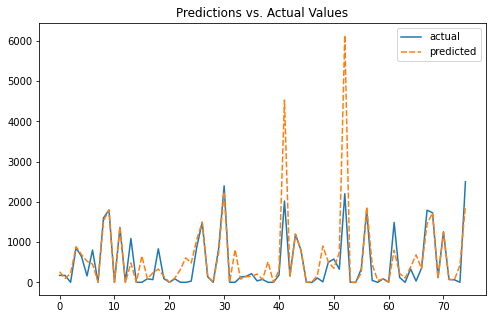

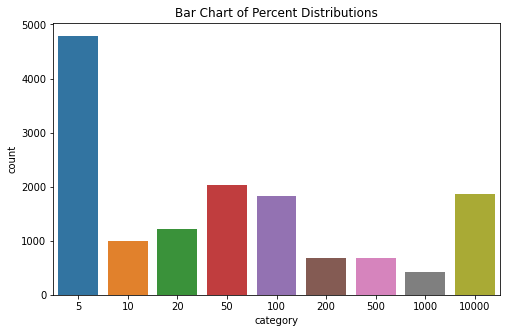

In [11]:
modelReport(yTest, testPreds)
